## Chapter6.2 学習とテスト

In [1]:
# testdatasetというデータセットを作成、既にあれば新たに作る必要はない
# !bq mk testdataset

# wdbc テープルを作成
# !bq load --autodetect testdataset.wdbc ../datasets/wdbc.csv

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pandas DataFrameに読み込みます
<font color="red">**PROJECTID**を書き換えて実行してください</font>

In [3]:
# BigQueryクエリ結果をDataFrameに読み込む
query = 'SELECT * FROM testdataset.wdbc ORDER BY index'
dataset = pd.read_gbq(project_id='PROJECTID', query=query)

# データの先頭５行を表示
dataset.head()

Requesting query... ok.
Query running...
Query done.
Processed: 139.5 kb

Retrieving results...
Got 569 rows.

Total time taken 2.16 s.
Finished at 2017-09-26 22:14:59.


,index,diagnostic,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,...,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension
0,8670,M,15.46,19.48,101.70,748.9,0.10920,0.12230,0.14660,0.08087,...,19.26,26.00,124.90,1156.0,0.15460,0.2394,0.3791,0.15140,0.2837,0.08019
1,8913,B,12.89,13.12,81.89,515.9,0.06955,0.03729,0.02260,0.01171,...,13.62,15.54,87.40,577.0,0.09616,0.1147,0.1186,0.05366,0.2309,0.06915
2,8915,B,14.96,19.10,97.03,687.3,0.08992,0.09823,0.05940,0.04819,...,16.25,26.19,109.10,809.8,0.13130,0.3030,0.1804,0.14890,0.2962,0.08472
3,9047,B,12.94,16.17,83.18,507.6,0.09879,0.08836,0.03296,0.02390,...,13.86,23.02,89.69,580.9,0.11720,0.1958,0.1810,0.08388,0.3297,0.07834
4,85715,M,13.17,18.66,85.98,534.6,0.11580,0.12310,0.12260,0.07340,...,15.67,27.95,102.80,759.4,0.17860,0.4166,0.5006,0.20880,0.3900,0.11790


データの整形

In [4]:
# 'M'を0, 'B'を1に変換
dataset['diagnostic'] = dataset['diagnostic'].apply(
    lambda x: 0 if x == 'M' else 1)

# 'index'カラムを削除
dataset.drop('index', axis=1, inplace=True)

In [5]:
# DataFrameからarrayに変換
X_dataset = dataset.drop('diagnostic', axis=1).as_matrix()
y_dataset = dataset.diagnostic.as_matrix()

学習とテストデータの分割

In [6]:
from sklearn.model_selection import train_test_split

# 学習用とテスト用にデータセットを分ける
X_train, X_test, y_train, y_test = train_test_split(
    X_dataset, y_dataset, test_size=0.2, random_state=42)

ランダムフォレストで識別

In [7]:
from sklearn.ensemble import RandomForestClassifier

# 識別器のインスタンスを生成
classifier = RandomForestClassifier(random_state=42)

# 学習用データを学習
classifier.fit(X_train, y_train)

# テスト用データで推論し、正解率を算出
classifier.score(X_test, y_test)

0.92982456140350878

SVMで識別

In [8]:
from sklearn.svm import SVC

# 識別器のインスタンスを生成
classifier = SVC()

# 学習用データを学習
classifier.fit(X_train, y_train)

# テスト用データで推論し、正解率を算出
classifier.score(X_test, y_test)

0.59649122807017541

データのレンジを合わせる

In [9]:
from sklearn.preprocessing import MinMaxScaler

# 最大値が1、最小値が0になるよう各特徴量をスケールする
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 再度、学習と推論を行う
classifier.fit(X_train, y_train)
classifier.score(X_test, y_test)

0.94736842105263153

K-Fold クロスバリデーション

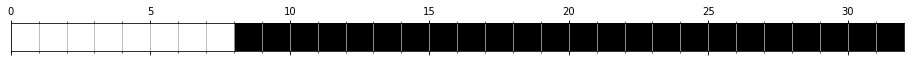

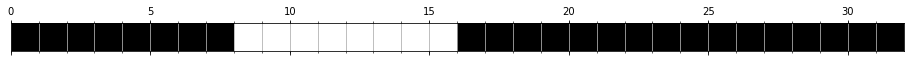

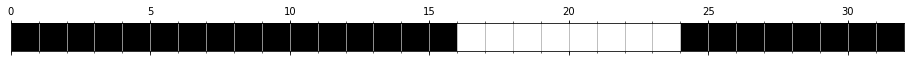

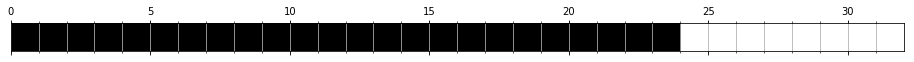

In [10]:
from sklearn.model_selection import KFold

# データを４分割するモード
kf = KFold(n_splits=4, random_state=42, shuffle=False)
test_data = np.zeros(32)

# 学習用とテスト用に分割された配列のインデックスを取得
for train_index, test_index in kf.split(test_data):
    # test_indexのインデックスだけ値を1にし、他は0の配列を作る
    dat = np.zeros(32)
    dat[test_index] = 1

    # データを可視化
    plt.gray()
    plt.matshow(dat.reshape(1, 32), extent=[0, 32, 0, 1])
    plt.gca().set_yticks([])
    plt.gca().set_xticks(range(32), minor='true')
    plt.grid(which='minor')
    plt.show()

KFoldクロスバリデーションでSVMを学習

In [11]:
# 識別器のインスタンスを作成
classifier = SVC()

kf = KFold(n_splits=4, random_state=42, shuffle=True)
for train_index, test_index in kf.split(X_dataset):
    # データセットを学習とテストに分ける
    X_train, X_test = X_dataset[train_index], X_dataset[test_index]
    y_train, y_test = y_dataset[train_index], y_dataset[test_index]

    # スケール
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # 学習と正解率の算出
    classifier.fit(X_train, y_train)
    print(classifier.score(X_test, y_test))

0.937062937063
0.93661971831
0.964788732394
0.943661971831
